# Tagup Data Science Exercise

ExampleCo, Inc is gathering several types of data for its fleet of very expensive machines.  These very expensive machines have three operating modes: *normal*, *faulty* and *failed*.   The machines run all the time, and usually they are in normal mode.  However, in the event that the machine enters faulty mode, the company would like to be aware of this as soon as possible.  This way they can take preventative action to avoid entering failed mode and hopefully save themselves lots of money.

They collect four kinds of timeseries data for each machine in their fleet of very expensive machines.  When a machine is operating in *normal* mode the data behaves in a fairly predictable way, but with a moderate amount of noise.  Before a machine fails it will ramp into *faulty* mode, during which the data appears visibly quite different.  Finally, when a machine fails it enters a third, and distinctly different, *failed* mode where all signals are very close to 0.

You can download the data here: [exampleco_data](https://drive.google.com/open?id=1b12u6rzkG1AxB6wLGl7IBVoaoSoZLHNR)

__Your main objective: to develop an automated method to pinpoint the times of fault and failure in this machine__.  Keep in mind that you will be sharing these results with the executives at ExampleCo, so to the best of your ability, try to explain what you are doing, what you've shown, and why you think your predictions are good.


A few notes to help:
1. A good place to start is by addressing the noise due to communication
   errors.
2. Feel free to use any libraries you like, or even other programming
   languages. Your final results should be presented in this notebook, however.
3. There are no constraints on the techniques you bring to bear, we are curious
   to see how you think and what sort of resources you have in your toolbox.
4. Be sure to clearly articulate what you did, why you did it, and how the
   results should be interpreted. In particular you should be aware of the
   limitations of whatever approach or approaches you take.
5. Don't feel compelled to use all the data if you're not sure how. Feel free
   to focus on data from a single unit if that makes it easier to get started.
6. Don't hesitate to reach out to datasciencejobs@tagup.io with any questions!

### Using LSTM-Autoencoders to pinpoint the times of fault and failure (Anomaly Detection) in a machine based on Reconstruction Errors learnt over ***assumed normal Time Series***

#### Major Assumptions:

- We assumed that the training data are times when the machine are in **Normal Mode.**

- We assumed that **Moving Window Average, a low pass filter (With window size == 25)** has the ability to filter out unwanted noise due to communication errors from the intended data.

- We are assumed that times of fault and failures in the data are ***anomalies***



<img src="files/anomaly.png" width="800" height="400">

### Steps Ahead

- Load in Data and necessary libraries
- Data exploration
- Noise Removal using Moving Window Average
- Data Splitting
- Data preparation
- Implementation of LSTM Autoencoder
- Data visualization to pinpoints times of fault and failures ***(~ to detect anomalies)***

### - Loading in Data and Data Exploration

In [1]:
#import necessary libraries
import keras
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
from datetime import datetime

from keras import optimizers, Sequential
from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
#set the data visualization parameters

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (16, 8),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

In [3]:
#load in data
df_machine_0 = pd.read_csv('machine_0.csv', index_col = 0)

In [4]:
df_machine_0.head()

,0,1,2,3
2019-01-01 00:00:00.000000000,12.626096,8.803120,-11.809200,10.083961
2019-01-01 08:00:09.603201067,10.831994,2.816327,11.554778,21.892853
2019-01-01 16:00:19.206402134,21.083510,-0.672645,-17.839178,-1.349024
2019-01-02 00:00:28.809603201,32.294495,6.525132,-13.498586,-4.250752
2019-01-02 08:00:38.412804268,28.057100,3.691359,21.984744,13.670561


In [5]:
#Defining some helper functions

def index_to_date(df):
    '''
    This function convert the dataframe index to a Year-Month-Date Time format
    '''
    df.index = pd.to_datetime(df.index, format= '%Y-%m-%d %H:%M:%S.%f')
    df.index = df.index.map(lambda t: t.strftime('%Y-%m-%d'))
    
    return df.index


#moving average
def moving_window_average(df, window):
    '''
    The moving average filter is a simple Low Pass FIR (Finite Impulse Response) filter,
    commonly used for smoothing an array of sampled data/signal. 
    
    At a timestep, an arithmetic mean is taken from a specified number of data points to produce a singular output point.
    the number of the data points needed to compute an average for each time step is refered to as "window"
    
    The averaging window is moved over the data, shifting it by one time step after each calculation ("moving average").
    
    '''
    
    dict_col = {}
    for columns in df.columns:
        dict_col["smooth_data_" + columns] = pd.Series(df[columns]).rolling(min_periods = 1, window=window).mean()
    
    df_smooth = pd.DataFrame(dict_col, index = df.index)
    
    return df_smooth

In [6]:
df_machine_0.index = index_to_date(df_machine_0)

In [7]:
df_machine_0.head(2)

,0,1,2,3
2019-01-01,12.626096,8.803120,-11.809200,10.083961
2019-01-01,10.831994,2.816327,11.554778,21.892853


In [8]:
#check the size of the df
df_machine_0.shape

(3000, 4)

In [9]:
#check for null values
df_machine_0.isnull().sum()

0    0
1    0
2    0
3    0
dtype: int64

In [10]:
#Descriptive statistics of the dataframe
df_machine_0.describe()

,0,1,2,3
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,-0.816016,-1.091308,1.267945,0.165844
std,58.078319,55.965665,56.538700,56.910659
min,-323.954437,-258.780879,-287.153920,-365.362164
25%,-0.008684,-0.008851,-0.008274,-0.007883
50%,-0.000402,-0.000085,0.000669,0.000310
75%,0.007832,0.008373,0.009056,0.008685
max,315.738951,264.374782,281.684102,340.513819


In [11]:
#check when the last date the data was collected
df_machine_0.tail(1)

,0,1,2,3
2021-09-27,0.003465,0.023451,0.012463,0.013997


**The last date the time series data for this machine was collected was on September, 27 2021**

In [12]:
#Another helper function for data visualization

def plot_signal(df):
    
    df.plot()
    plt.xticks(rotation=25)     
    plt.title('Sensor Signal of the Machine')
    plt.xlabel('Time')
    plt.ylabel('Amplitude (db)')
    plt.legend(bbox_to_anchor=(1, 1), loc=2, labels = ['SensorSignal_0', 'SensorSignal_1', 'Sensorsignal_2', 'Sensorsignal_3'])
    

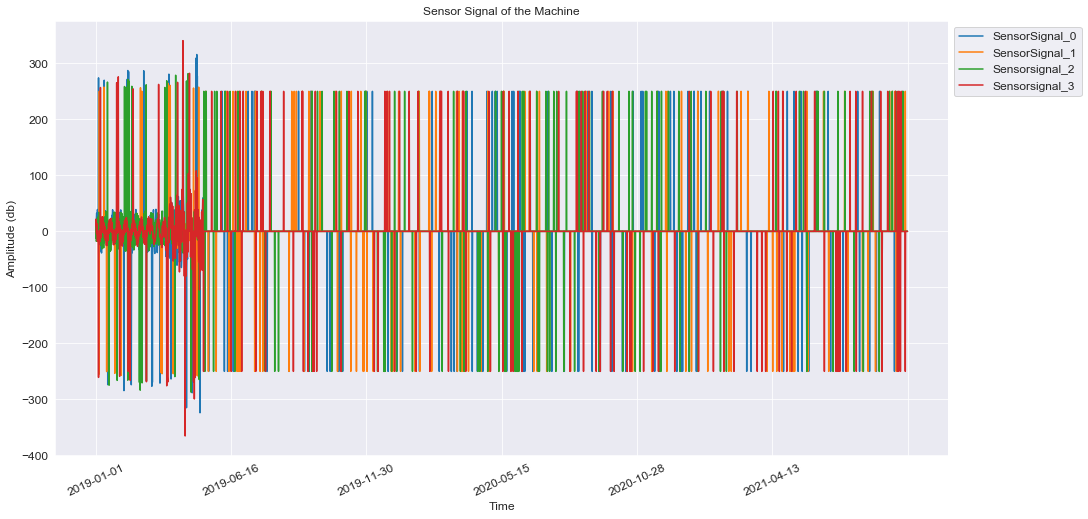

In [13]:
#visualize the df
plot_signal(df_machine_0)

In [14]:
#denoise the data
df_smooth = moving_window_average(df_machine_0,25)

***we smoothened the entire data to make sure the frequency response for the whole dataset (both noisy data and un-noisy ones) are similar***

- Here, There reason we chose window size == 25, is simply because we could observe some smoothening in the denoise part of the data even though the higher the window size causes low resolution as seen an the y-axis (amplitude).

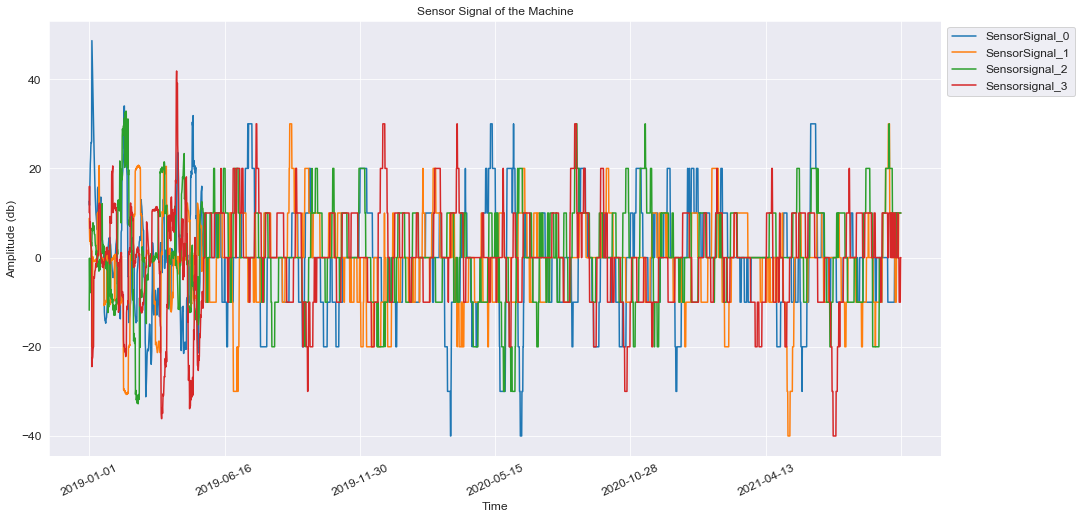

In [15]:
#visualize the de-noised data

plot_signal(df_smooth)

In [16]:
#recheck the smoothened/de-noise data
df_smooth.head()

,smooth_data_0,smooth_data_1,smooth_data_2,smooth_data_3
2019-01-01,12.626096,8.803120,-11.809200,10.083961
2019-01-01,11.729045,5.809723,-0.127211,15.988407
2019-01-01,14.847200,3.648934,-6.031200,10.209263
2019-01-02,19.209024,4.367983,-7.898047,6.594260
2019-01-02,20.978639,4.232658,-1.921488,8.009520


### - Data Splitting

Here we will assume that the **training data represent data that is said to be normal i.e. without fault or failure, even though there is possibility of the data to be faulty or have failed**, while **the test data is said to be data that could be** ***normal, faulty or failed*** this wil be known when we compare the reconstruction error of the training data to the test data.

The data is divided as follows: ***75% training data; 25% test data,*** this was done because we assumed that from the year ***2021*** there is high possibility that the performance of the machine may not be on par (i.e. may not meet the normal standard) compared to its performance at the beginning of ***2019*** when it started running.

In [17]:
#lets split

train_size = int(len(df_smooth) * 0.75)
test_size = int(len(df_smooth) - train_size)

In [18]:
#data splitting

train = df_smooth.iloc[0:train_size]
test = df_smooth.iloc[train_size:len(df_smooth)]
print(train.shape, test.shape)

(2250, 4) (750, 4)


In [19]:
#Notice the test data starts from 20th Janaury, 2021

test.head()

,smooth_data_0,smooth_data_1,smooth_data_2,smooth_data_3
2021-01-20,9.999098,-0.001271,0.000224,-9.996455
2021-01-20,9.999710,-0.001214,-0.000132,-9.996075
2021-01-20,9.999520,-0.000742,-0.000559,0.005062
2021-01-21,9.999589,-0.000377,-0.000624,0.004452
2021-01-21,10.000206,-0.000137,9.999231,0.004733


### Data Preprocessing


- Due to the features in our data having different numerical values that defer greatly from one another i.e. a feature have 10.0 while another one has -0.002, we decided to scale the data using Standard Scaler.


- Standard Scaler reconstructs or scales the data (all features) to have a zero mean and a standard deviation of one. Firstly by subtracting the mean it brings the values around 0 – so has zero mean. Secondly, it divides the values by standard deviation thereby ensuring that the resulting distribution is standard with a mean of 0 and standard deviation of 1. **[reference](http://rajeshmahajan.com/standard-scaler-v-min-max-scaler-machine-learning/).**


- Note that we normalize the training data (i.e. fit and transform), and use its summary statistics to normalize the test data (i.e. only transform) (for normalization, these statistics are the mean and variances of each feature). ***This is because the test data should be completely unseen to anything during the modeling.***

In [20]:
#instantiate the standardScaler
scaler = StandardScaler()

In [21]:
#normalize the data to have mean == 0; and Std == 1
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [22]:
#to confirm mean == 0
np.mean(train_scaled, axis = 0).round(6)

array([-0., -0., -0.,  0.])

In [23]:
#to confirm std == 0
np.var(train_scaled, axis = 0)

array([1., 1., 1., 1.])

In [24]:
#we converted back our data to df simply because we will still need in later sections
df_train = pd.DataFrame(train_scaled, index = train.index)
df_test = pd.DataFrame(test_scaled, index = test.index)

### - Building and Implementation of the LSTM Autoencoder Model

### Brief overview of LSTM Autoencoder model and the reason why we decided to use it

#### Autoencoder and Reconstruction Error

- Autoencoder: are neural networks that aim to reconstruct their input. They consist of two parts: ***an encoder and a decoder.*** The encoder maps input data to a latent space (or hidden representation) and the decoder maps back from latent space (~ hidden representation) to input space.


- Typically the latent space  has a lower dimensionality than the input space and, hence, Autoencoders are forced to learn compressed representations of the input data which enables them to captures the correlations and interactions between the input data.


- The autoencoder is trained to reconstruct data with **normal pattern (e.g., normal time series)** by minimizing a loss function that measures the quality of the reconstructions. After training, the model can now reconstruct the normal data well enough with minimal reconstruction error. 


- Once training is completed, the reconstruction error is used afterwards as an **anomaly score** to detect anomaly in future time instance of the data i.e. if the model is given an anomalous sequence of the data in future time that is **NOT NORMAL**, it may not be able to reconstruct it well and hence would lead to **higher reconstruction error** compared to the resconstruction errors for the normal sequence. This is reason why we **have to assume that the training data is said to be in NORMAL STATE**


#### LSTM Autoencoder and reason why we used it

- LSTM (Long Short Term Memory) is an upgraded Recurrent Neural Network (RNN), a powerful sequence learner with a memory cell and gates that control the information to include, remove and output from the memory cell. The major attribute of LSTM in comparision to RNN is the **memory cell** that stores **long to short term** information about input sequence across the timesteps.


- In our case, LSTM Autoencoder will be used for sequence to sequence (seq2seq) learning i.e. the encoder reads a variable-length input sequence and converts it into a fixed-length vector representation (reduced dimension), and the decoder takes this vector representation and converts it back into a variable length sequence.


- In general, the learned vector representation corresponds to the final hidden state of the encoder network, which acts like a summary of the whole sequence. Our LSTM Autoencoder is an example of Seq2Seq autoencoder, in which the input and output sequences are aligned in time (x = y) and, thus, have equal lengths (Tx = Ty).


- ***Reason we used LSTM Autoencoder:***


- We used LSTM Autoencoder simply because our time series data is a sequential data and LSTM captures the temporal dependencies of the data by introducing memory.


- Specifically, LSTM has the ability to capture long term temporal interactions and correlations between variables in the input sequence which is highly required in this scenario since this relationship are time dependent and they determine the state of the machine.


In [25]:
#Another helper function for building the required 3D Input [samples, time_steps, n_features]

def LSTM_3D_Input(X, time_steps): 
    '''
    This function takes in a dataframe that is intended to be used as LSTM Input data 
    and transform the data from 2D input structure(Samples, features) to 
    3D input structure [samples, time_steps, n_features].
    This is required for all LSTM Model structure in Keras.
    '''
    X_3D, y_2D = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        X_3D.append(v)
    return np.array(X_3D)

- Below, we define our **Timestep is equal to 21,** This is because for each day in our data the signals were recorded three times i.e. taken between 12 midnight - 8am, 8am - 4pm, 4pm - 12 midnight, and we want the LSTM to look back  for one week **(look at past event through out last week)** for each feature in an input sequence before deciding the output. 

In [26]:
#transform the train data into 3D form
time_steps = 21;
x_train = LSTM_3D_Input(train_scaled, time_steps)

In [27]:
#this is primarily going to be used as the input and output for our LSTM model
print(x_train.shape)

(2229, 21, 4)


In [28]:
#transform the test data into 3D form
time_steps = 21;
x_test = LSTM_3D_Input(test_scaled,time_steps)

In [29]:
#this is primarily going to be used as the input and output for our LSTM model
print(x_test.shape)

(729, 21, 4)


Because the train and test dataframes are less than the lstm input due to the timesteps required in LSTM, we will create a new dataframe(found below this cell) based on the number of samples in the lstm output, this dataframes will be used when creating the reconstruction error dataframes based on the lstm model output.

In [30]:
#because the lstm test and train data df are less than the df_train and df_test
#we need this:
time_steps = 21
df_train_lstm = df_train.iloc[time_steps:]
df_test_lstm = df_test.iloc[time_steps:]

In [31]:
#Another helper function to flatten out the 3D LSTM output to 2D output.

def flatten_to_2d(X):
    '''
    This flattens back the 3D LSTM output to the normal 2D output 
    which is required for obtain our reconstruction error.
    
    X: A 3D array from lstm with shape == [sample, timesteps, features].
    flat_X  A 2D array, sample x features.
    '''
    flat_X = np.empty((X.shape[0], X.shape[2]))  # obtain sample-->[0] and features only-->[2].
    for i in range(X.shape[0]):
        flat_X[i] = X[i, (X.shape[1]-1), :] #take the sample, with the last value in time step and with all the features
    return(flat_X)


In [32]:
#LSTM parameters
lr = 0.0001
adam = optimizers.Adam(lr)

In [33]:
#Building the LSTM model itself using KERAS

lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(32, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(x_train.shape[1]))
# Decoder
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(x_train.shape[2])))

lstm_autoencoder.compile(loss='mse',optimizer=adam)
lstm_autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 21, 32)            4736      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 21, 16)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 21, 16)            2112      
_________________________________________________________________
lstm_4 (LSTM)                (None, 21, 32)            6272      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 21, 4)             132       
Total params: 16,388
Trainable params: 16,388
Non-trainable params: 0
__________________________________________________

**Short Overview of the LSTM (- Long Short Term Memory) Autoencoder Architecture**

- **Note  x_train.shape[1] == 21 timesteps;  x_train.shape[2] == 4 features**


- The input data has 21 timesteps and 4 features.

- Layer 1, LSTM(32), reads the input data and outputs 32 features, each having 21 timesteps because ``return_sequences=True.``

- Layer 2, LSTM(16), takes the 21 x 32 input data from Layer 1 and reduces the feature size to 16. Since ``return_sequences=False``, it outputs a feature vector of size 1 x 16.

- The output of this layer is the **encoded feature vector** of the input data.

- Layer 3, RepeatVector(21), replicates the feature vector 21 times.

- The RepeatVector layer acts as a bridge between the encoder and decoder modules, It prepares the 2D array input for the first LSTM layer in Decoder.

- The Decoder layer is designed to unfold the encoding.

- Therefore, the Decoder layers are stacked in the reverse order of the Encoder.

- Layer 4, LSTM (16), and Layer 5, LSTM (32), are the mirror images of Layer 2 and Layer 1, respectively.

- Layer 6, TimeDistributed(Dense(4)), is added in the end to get the output, where “4” is the number of features in the input data.

**[reference](https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352).**


In [34]:
lstm_autoencoder_history = lstm_autoencoder.fit(
    x_train, x_train,
    epochs=200,
    batch_size=64,
    validation_split=0.1,
    shuffle=False
)


Train on 2006 samples, validate on 223 samples
Epoch 1/200
2006/2006 [==============================] - 3s 1ms/step - loss: 1.0200 - val_loss: 0.8412
Epoch 2/200
2006/2006 [==============================] - 1s 582us/step - loss: 1.0162 - val_loss: 0.8390
Epoch 3/200
2006/2006 [==============================] - 1s 587us/step - loss: 1.0129 - val_loss: 0.8372
Epoch 4/200
2006/2006 [==============================] - 1s 583us/step - loss: 1.0095 - val_loss: 0.8354
Epoch 5/200
2006/2006 [==============================] - 1s 663us/step - loss: 1.0056 - val_loss: 0.8334
Epoch 6/200
2006/2006 [==============================] - 1s 701us/step - loss: 1.0003 - val_loss: 0.8309
Epoch 7/200
2006/2006 [==============================] - 1s 629us/step - loss: 0.9920 - val_loss: 0.8269
Epoch 8/200
2006/2006 [==============================] - 1s 590us/step - loss: 0.9765 - val_loss: 0.8199
Epoch 9/200
2006/2006 [==============================] - 1s 603us/step - loss: 0.9733 - val_loss: 0.8140
Epoch 10/2

Epoch 78/200
2006/2006 [==============================] - 1s 574us/step - loss: 0.4897 - val_loss: 0.4927
Epoch 79/200
2006/2006 [==============================] - 1s 564us/step - loss: 0.4880 - val_loss: 0.4866
Epoch 80/200
2006/2006 [==============================] - 1s 567us/step - loss: 0.4858 - val_loss: 0.4902
Epoch 81/200
2006/2006 [==============================] - 1s 568us/step - loss: 0.4837 - val_loss: 0.4864
Epoch 82/200
2006/2006 [==============================] - 1s 573us/step - loss: 0.4778 - val_loss: 0.4768
Epoch 83/200
2006/2006 [==============================] - 1s 576us/step - loss: 0.4705 - val_loss: 0.4762
Epoch 84/200
2006/2006 [==============================] - 1s 569us/step - loss: 0.4649 - val_loss: 0.4740
Epoch 85/200
2006/2006 [==============================] - 1s 572us/step - loss: 0.4629 - val_loss: 0.4656
Epoch 86/200
2006/2006 [==============================] - 1s 570us/step - loss: 0.4594 - val_loss: 0.4683
Epoch 87/200
2006/2006 [======================

Epoch 155/200
2006/2006 [==============================] - 1s 599us/step - loss: 0.3334 - val_loss: 0.3515
Epoch 156/200
2006/2006 [==============================] - 1s 624us/step - loss: 0.3332 - val_loss: 0.3512
Epoch 157/200
2006/2006 [==============================] - 1s 614us/step - loss: 0.3275 - val_loss: 0.3469
Epoch 158/200
2006/2006 [==============================] - 1s 596us/step - loss: 0.3289 - val_loss: 0.3518
Epoch 159/200
2006/2006 [==============================] - 1s 613us/step - loss: 0.3253 - val_loss: 0.3475
Epoch 160/200
2006/2006 [==============================] - 1s 604us/step - loss: 0.3227 - val_loss: 0.3491
Epoch 161/200
2006/2006 [==============================] - 1s 606us/step - loss: 0.3234 - val_loss: 0.3475
Epoch 162/200
2006/2006 [==============================] - 1s 593us/step - loss: 0.3229 - val_loss: 0.3499
Epoch 163/200
2006/2006 [==============================] - 1s 597us/step - loss: 0.3198 - val_loss: 0.3467
Epoch 164/200
2006/2006 [============

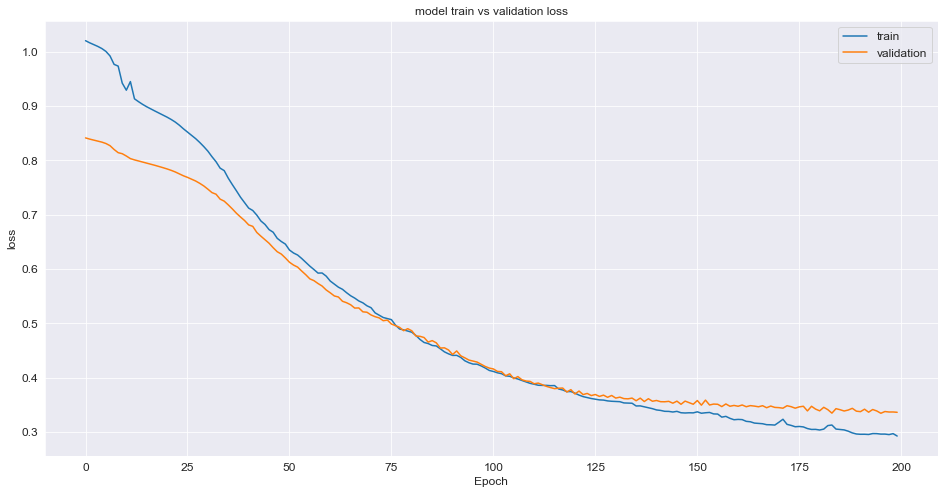

In [35]:
plt.plot(lstm_autoencoder_history.history['loss'], label='train loss')
plt.plot(lstm_autoencoder_history.history['val_loss'], label='Validation loss')
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')

- In regards to the validation loss not greater than the training loss initially, I tried using **regularization parameters such as dropout** but that did not solve the problem, I also tried increasing (and decreasing) the LSTM layers but that did not make the validation loss go down so I decided to change the learning rate to 0.0001 and increased the epoch training times and this was the result I got.


- But, I definitely know this could be better I will keep on trying to see if I could tweak more parameters to have the error decrease in the manner it should.

**Note that the Mean Absolute Error between the actual value and the predicted value for the training data will be our Reconstruction Error**

In [36]:
#make predictions and 
#generate the Mean Absolute Error (MAE) i.e. predicted value - actual value

x_pred = lstm_autoencoder.predict(x_train)
train_mae_loss = np.mean(np.abs(flatten_to_2d(x_pred) - flatten_to_2d(x_train)), axis = 1)

In [37]:
threshold = max(train_mae_loss).round(2)
print(threshold)

1.57


Text(0.5, 1.0, 'Distribution of Mean Absolute Error')

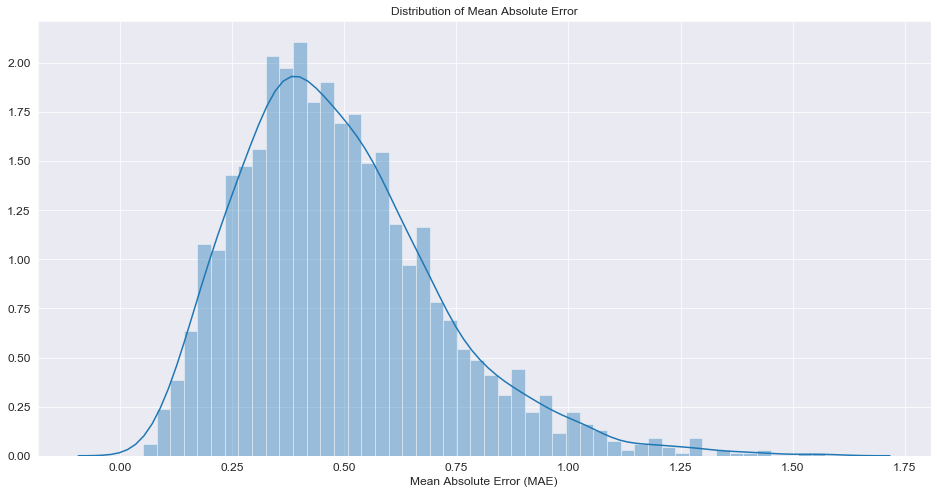

In [38]:
sns.distplot(train_mae_loss, bins=50, kde=True)
plt.xlabel('Mean Absolute Error (MAE)')
plt.title('Distribution of Mean Absolute Error')

- From the above MAE loss distribution, we will take **1.57** as our threshold. This specific value will be used to flag for an anomaly i.e. a faulty or failed machine. 

In [39]:
#make predictions and 
#generate the Mean Absolute Error (MAE) i.e. predicted value - actual value

x_pred_test = lstm_autoencoder.predict(x_test)
test_mae_loss = np.mean(np.abs(flatten_to_2d(x_pred_test) - flatten_to_2d(x_test)), axis = 1)

In [40]:
#Another helper function for creating the reconstructed df for train and test data and further concatenates them both

def reconstructed_df(mae_loss, df, threshold):
    
    '''
    This basically creates a dataframe with columns that consist of 
    the Mae_loss, threshold and anomaly.
    '''
    
    df_t = pd.DataFrame(index=df.index)
    df_t['Loss_mae'] = mae_loss
    df_t['Threshold'] = threshold
    df_t['Anomaly'] = df_t['Loss_mae'] > df_t['Threshold']
    return df_t

In [41]:

df_recon_train = reconstructed_df(train_mae_loss, df_train_lstm, threshold)
df_recon_test = reconstructed_df(test_mae_loss, df_test_lstm, threshold)

In [42]:
print(df_recon_train.shape, df_recon_test.shape)

(2229, 3) (729, 3)


In [43]:
df_machine = pd.concat([df_recon_train, df_recon_test])

In [44]:
df_machine.shape

(2958, 3)

In [45]:
df_machine.head()

,Loss_mae,Threshold,Anomaly
2019-01-08,0.257109,1.57,False
2019-01-08,0.296412,1.57,False
2019-01-08,0.289697,1.57,False
2019-01-09,0.347819,1.57,False
2019-01-09,0.349165,1.57,False


In [46]:
df_anomaly = df_machine[df_machine['Anomaly'] == True]

In [47]:
df_anomaly.shape

(38, 3)

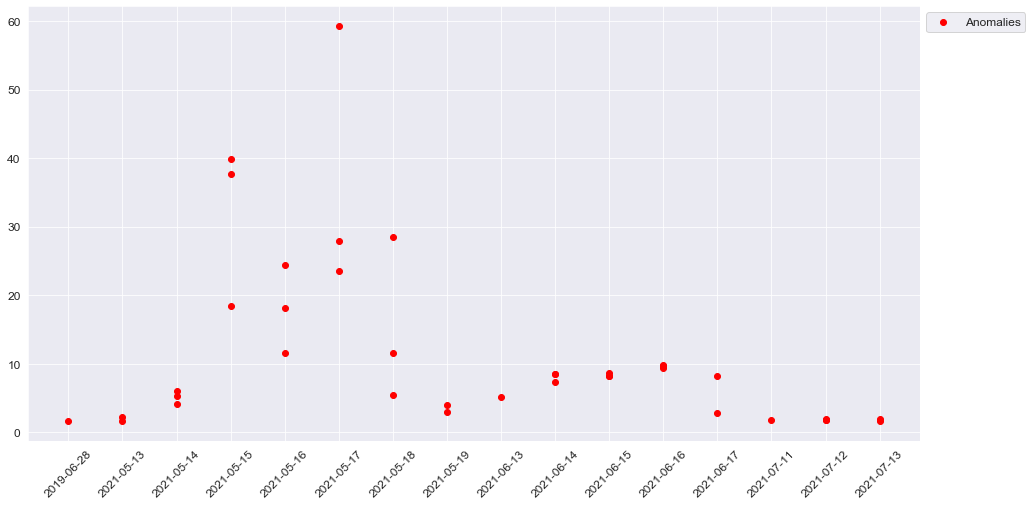

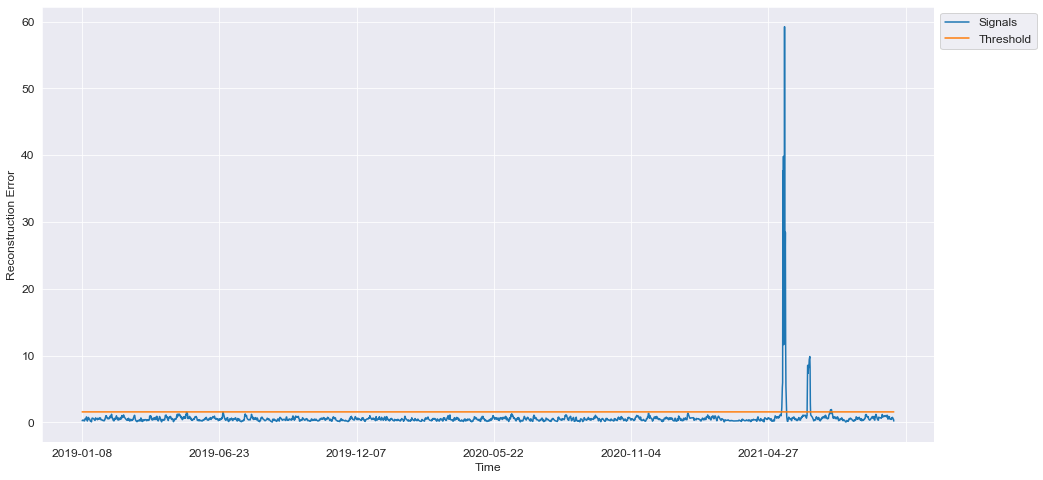

In [48]:
plt.scatter(df_anomaly.index, df_anomaly.Loss_mae, c = 'red')
plt.legend(bbox_to_anchor=(1, 1), loc=2, labels = ['Anomalies'])
plt.xticks(rotation = 45)
df_machine.plot()
plt.xticks()
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.legend(bbox_to_anchor=(1, 1), loc=2, labels = ['Signals', 'Threshold'])

Text(0.5, 1.0, 'Times of faults and failures (anomalies) in the Machine')

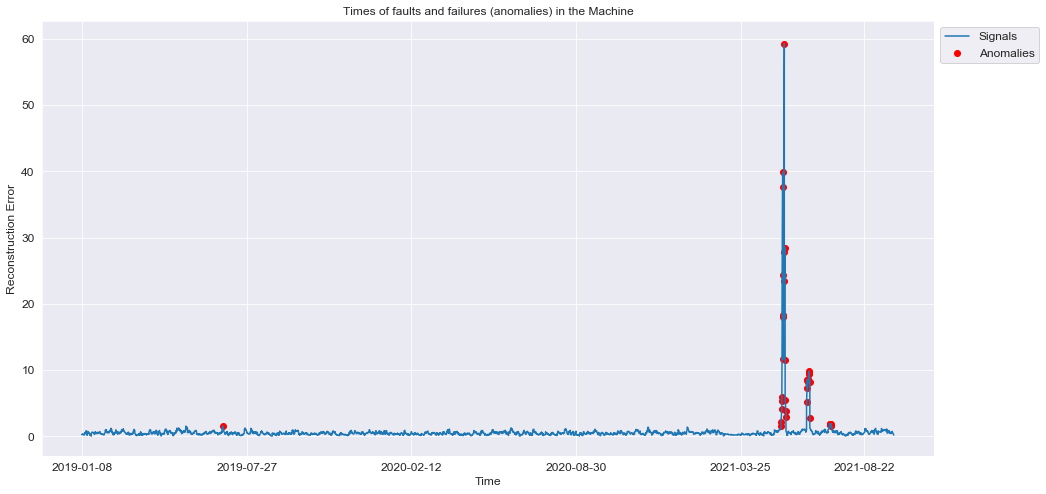

In [49]:
plt.plot(df_machine.index, df_machine.Loss_mae)
plt.scatter(df_anomaly.index, df_anomaly.Loss_mae, c = 'red')
plt.xticks([0, 200, 400, 600, 800, 950]) 
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.legend(bbox_to_anchor=(1, 1), loc=2, labels = ['Signals', 'Anomalies'])
plt.title('Times of faults and failures (anomalies) in the Machine')

**Summary:**

- I believe the predictions are good because the model takes into account the behaviour of the signals over time and the error shows consistent decrease with increasing epochs.

- Based on our results, LSTM Autoencoder is a robust model for detecting anomalies in time-series data, this is because it takes into account the temporal dependencies of the input sequence.


- More data is required for **each single machine** to be able to justify the findings of these results because the more data for a single machine the more robust the model for predicting times of anomalies for the machine.